In [ ]:
%matplotlib inline
from __future__ import division
import numpy as np

import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import networkx as nx
from djPyi2 import mpltools
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import matplotlib.patches as patches
from djPyi2 import Common as CM
import matplotlib.image as mpimg

import numpy as np
import matplotlib.cm as cm

from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick

In [ ]:
import scipy.stats as sps

from djPyi2 import stats as dj_stats

dy_name = 'Figures'
private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

In [ ]:
def get_labs_ax5(ax5, burden_ave_sb_all):
    """ get the burden plot labels from the data for annotation"""
    min_yticks = min(ax5.get_yticks())
    max_yticks = max(ax5.get_yticks())

    labels_burden_per_bar = []
    xtick_locs_burden_per_bar = []
    ytick_locs_burden_per_bar = []
    start = max_yticks
    for cat in reversed(order_super_burd):
        inds = burden_ave_sb_all.loc[cat, order_svt_burd].sum(axis = 1).tolist()
        inds = list(reversed(inds))
        l = mpltools.format_base_pair_scale(inds, mb_round=1, )
        labels_burden_per_bar.append(l)
        xtick_locs_burden_per_bar.append(inds)

        yticks = [start + 0.25, start, start-0.25]
        ytick_locs_burden_per_bar.append(yticks)
        start -= 1

    labels_burden_per_bar = CM.flatten_list(labels_burden_per_bar)
    xtick_locs_burden_per_bar = CM.flatten_list(xtick_locs_burden_per_bar)
    ytick_locs_burden_per_bar = CM.flatten_list(ytick_locs_burden_per_bar)
    
    return labels_burden_per_bar, xtick_locs_burden_per_bar, ytick_locs_burden_per_bar

In [ ]:
def add_svtype_cats(all_qtls_filt):
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV', 'SNV': 'SNV', 'INDEL_DEL': 'INDEL', 
               'INDEL_INS': 'INDEL'}
    all_qtls_filt['SVTYPE_SUPER'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x, 'SV'))
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV',
               'ALU': 'MEI', 'LINE1': 'MEI', 'SVA':'MEI', 'rMEI':'MEI', 
          'DUP': 'CNV', 'DEL': 'CNV', 'mCNV': 'CNV', 'SNV': 'SNV', 'INDEL_INS': 'INDEL', 'INDEL_DEL': 'INDEL', 
              'INDEL': 'INDEL', 'SNP': "SNV"}
    all_qtls_filt['SVTYPE_COLLAPSE'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x, 'other SV'))
    convert = {'LINE1':'MEI', 'SVA': 'MEI', 'ALU': 'MEI'}
    all_qtls_filt['SVTYPE_NR_C'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x,x))
    return all_qtls_filt

In [ ]:
def compute_mannu_vs_str(lev, col_dist, order_vars_c, col_comp = 'SVTYPE_NR_C', comp_cat = 'STR', 
                        alternative = None):
    obs = lev[lev[col_comp] == comp_cat][col_dist].tolist()
    data = []
    for i in order_vars_c:
        comp = lev[lev[col_comp]== i][col_dist].tolist()
    #     obs = lev[lev.SVTYPE_NR_C != i].num_egenes_lead.tolist()
        mu, p = sps.mannwhitneyu(comp, obs, alternative=alternative)
        mean_c = np.mean(comp)
        t, p_t = sps.ttest_ind(comp, obs)
        data.append([mu, p, i, mean_c, t, p_t, col_dist])
    stats = pd.DataFrame(data, columns = ['mu', 'p_value', 'SVTYPE_NR_C', 'mean_c', 'T', 'p_value_t',
                                          "variable"])
    stats['p_bonf'] = stats['p_value'] * (stats.shape[0] -1)
    inds = stats[stats.p_bonf > 1].index.tolist()
    if len(inds) > 0:
        stats.loc[inds, 'p_bonf'] = 1
    stats['p_bonf_t'] = stats['p_value_t'] * (stats.shape[0] -1)
    
    inds = stats[stats.p_bonf_t > 1].index.tolist()
    if len(inds) > 0:
        stats.loc[inds, 'p_bonf_t'] = 1        
    stats = stats.set_index('SVTYPE_NR_C', drop = False)
    return stats

# Data Import and Prep

In [ ]:
fn_gwas = '/frazer01/home/matteo/analysis/i2qtl_sv/ld/sv2ukbb_table.txt'

gwas = pd.read_table(fn_gwas)
ld_max_ukbb = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gwas_ld_ukbb/qtl_results_v4/ld_max_ukbb_eqtl_vars.pkl')

In [ ]:
per_variant_info_sv_only = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/per_variant_info_annot_update.pkl')

In [ ]:
per_variant_info_sv_only = per_variant_info_sv_only.join(ld_max_ukbb.set_index('SV_ID'),how = 'left')
per_variant_info_sv_only['tested_ld_w_ukbb'] = (per_variant_info_sv_only.r2_max.isnull() == False)

In [ ]:
per_variant_info_sv_only['strong_ld'] = per_variant_info_sv_only.r2_max > 0.8

In [ ]:
per_variant_info_sv_only = per_variant_info_sv_only.pipe(add_svtype_cats)

In [ ]:
pvt = per_variant_info_sv_only[per_variant_info_sv_only.tested_ld_w_ukbb]

In [ ]:
frac_strong_ld = pvt.groupby('SVTYPE_NR').strong_ld.value_counts(normalize = True)

In [ ]:
# fraction of linked vars that had a GWAS trait (overall)
a = pvt.groupby(('SVTYPE_NR', 'strong_ld')).has_ukbb.value_counts().to_frame('num_var')
b =  pvt.groupby(('SVTYPE_NR', 'strong_ld')).has_ukbb.value_counts(normalize = True).to_frame('fraction')
frac_w_trait = a.join(b)
frac_w_trait = frac_w_trait.loc(axis = 0)[:,True,:]

In [ ]:
# fraction of linked eVars that had a GWAS trait (overall)
pvt_nlv = pvt[pvt.lead_association == False]
a = pvt_nlv.groupby(('SVTYPE_NR', 'strong_ld')).has_ukbb.value_counts().to_frame('num_var')
b =  pvt_nlv.groupby(('SVTYPE_NR', 'strong_ld')).has_ukbb.value_counts(normalize = True).to_frame('fraction')
frac_w_trait_nlv = a.join(b)
frac_w_trait_nlv = frac_w_trait_nlv.loc(axis = 0)[:,True,:]
frac_w_trait_nlv['category'] = 'non-lead'

In [ ]:
pvt_lv = pvt[pvt.lead_association]
a = pvt_lv.groupby(('SVTYPE_NR', 'strong_ld')).has_ukbb.value_counts().to_frame('num_var')
b =  pvt_lv.groupby(('SVTYPE_NR', 'strong_ld')).has_ukbb.value_counts(normalize = True).to_frame('fraction')
frac_w_trait_lv = a.join(b)
frac_w_trait_lv = frac_w_trait_lv.loc(axis = 0)[:,True,:]
frac_w_trait_lv['category'] = 'lead'

In [ ]:
frac_w_trait_fp = pd.concat([frac_w_trait_lv, frac_w_trait_nlv])
frac_w_trait_fp = frac_w_trait_fp.reset_index()

In [ ]:
order_var = ['DEL', 'DUP', 'mCNV', 'INV', 'rMEI', 'ALU', 'LINE1', 'SVA', 'STR']
stats_comp_dists = compute_mannu_vs_str(pvt, 'r2_max', order_var, col_comp='SVTYPE_NR', comp_cat = 'STR')

# Stats

In [ ]:
order_var = ['DEL', 'DUP', 'mCNV', 'INV', 'rMEI', 'ALU', 'LINE1', 'SVA', 'STR']
stats_comp_dists_lower = compute_mannu_vs_str(pvt, 'r2_max', order_var, col_comp='SVTYPE_NR', comp_cat = 'STR', 
                                             alternative = 'less')

In [ ]:
stats_comp_dists_greater = compute_mannu_vs_str(pvt, 'r2_max', order_var, col_comp='SVTYPE_NR', comp_cat = 'STR', 
                                             alternative = 'greater')

In [ ]:
# Logistic regression model of number of egenes linked to variant versus linkage to ukbb trait
from statsmodels.formula.api import logit
from statsmodels.formula.api import ols
per_var['has_ukbb_bin'] = per_var.has_ukbb.astype(int)

models_dfs = []

for svt, df in per_var.groupby('SVTYPE_NR'):
    
    print svt
#     m = ols('num_egenes_lead ~ log10_SVLEN + dist_tss_abs + NMODE_AF', data= tdf).fit()
    m = logit('has_ukbb_bin ~ num_egenes_lead', data= df).fit()
    summary = m.summary2()
    summary = summary.tables[1]
    summary['SVTYPE']  = svt
    models_dfs.append(summary)
logit_models_svt_gwas = pd.concat(models_dfs)
logit_models_svt_gwas = logit_models_svt_gwas.loc['num_egenes_lead'].pipe(dj_stats.add_bh_fdr, 'P>|z|')
logit_models_svt_gwas = logit_models_svt_gwas.set_index('SVTYPE', drop = False)

In [ ]:
### fisher exact tests from enrichment of gwas trait linkage

enr_gwas_ukbb_svt = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gwas_ld_ukbb/qtl_results_v4/enr_gwas_ukbb_svt.pkl')
enr_gwas_ukbb_svt = enr_gwas_ukbb_svt.set_index('SVTYPE_NR', drop = False)

In [ ]:
enr_overall_ld_evar = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gwas_ld_ukbb/qtl_results_v4/enr_overall_ld_evar.pkl').set_index('SVTYPE_NR', drop = False)

In [ ]:
## fraction per svt linked to a trait among lead variants
gwas_frac_svt_th = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gwas_ld_ukbb/qtl_results_v4/gwas_frac_svt_th.pkl')

In [ ]:
pvt['strong_ld'] = (pvt.r2_max > 0.8)

In [ ]:
num_ld_ukbb = (pvt.groupby(("SVTYPE_NR", 'lead_association'))
               .strong_ld
               .value_counts()
               .to_frame('count').reset_index(level = [1,2]))

num_ld_ukbb_sig = (pvt.groupby(("SVTYPE_NR", 'significant_association'))
               .strong_ld
               .value_counts()
               .to_frame('count').reset_index(level = [1,2]))

frac_ld_ukbb = (pvt.groupby(("SVTYPE_NR", 'lead_association'))
                .strong_ld.value_counts(normalize = True)
                .to_frame('fraction').reset_index(level = [1,2]))

frac_ld_ukbb = frac_ld_ukbb.reset_index()

frac_ld_ukbb['cat'] = 'lead'

In [ ]:
frac_ld_sig_ukbb = (pvt.groupby(("SVTYPE_NR", 'significant_association'))
                .strong_ld.value_counts(normalize = True)
                .to_frame('fraction').reset_index(level = [1,2]))
frac_ld_sig_ukbb = frac_ld_sig_ukbb.reset_index()
frac_ld_sig_ukbb['cat'] = 'significant'

In [ ]:
def lambda_cap_group(x, thresh = 2, how = 'greater', alternate = False, type_out = float):
    if how =='greater':
        if x >= thresh:
            if alternate:
                return alternate
            else:
                return thresh
            
    if how == 'less':
        if x <= thresh:
            if althernate:
                return alternate
            else:
                return thresh
            
    return type_out(x)

per_var['cap_num_egenes_lead'] = per_var.num_egenes_lead.apply(lambda x: lambda_cap_group(x, 2))
per_var['label_num_egenes_lead'] = per_var.num_egenes_lead.apply(lambda x: lambda_cap_group(x, 2, 
                                                                                             alternate='2+', 
                                                                                           type_out = lambda x: str(int(x))))
per_var['cap_num_egenes'] = per_var.num_egenes.apply(lambda x: lambda_cap_group(x, 2))
per_var['label_num_egenes'] =  per_var.num_egenes.apply(lambda x: lambda_cap_group(x, 2, 
                                                                                   alternate='2+', 
                                                                                   type_out= (lambda x: int(x))))

vc_gwas_by_class = per_var.groupby(('SVTYPE_NR', 'label_num_egenes_lead')).has_ukbb.value_counts(normalize = True).loc(axis = 0)[:, :, True].to_frame('fraction_gwas').reset_index()

vc_gwas_by_class_num = per_var.groupby(('SVTYPE_NR', 'label_num_egenes_lead')).has_ukbb.value_counts(normalize = False).to_frame('num_variants')

t = per_var.groupby(('SVTYPE_NR', 'label_num_egenes_lead')).has_ukbb.value_counts(normalize = False).to_frame('fraction_variants')

vc_gwas_by_class_num = vc_gwas_by_class_num.join(t).reset_index()

vc_gwas_by_class_num['has_ukbb_str'] = vc_gwas_by_class_num.has_ukbb.astype(str)

In [ ]:
color_pal_svtypes_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/color_pal_svtypes_all.pkl').to_dict()
color_pal_comp_to_str = {k:'grey' for k,v in color_pal_svtypes_all.iteritems()}
color_pal_comp_to_str['STR'] = 'black'
order_var = ['DEL', 'DUP', 'mCNV', 'INV', 'rMEI', 'ALU', 'LINE1', 'SVA', 'STR']
color_pal_lead_sig = {'significant': 'grey', 'lead': '#7DCEA0', 'all': 'black'}

In [ ]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

In [ ]:
def buffer_lims(ax, frac = 0.2, buff_specific = False, axis = 'x', direction = 'max'):
    if (axis == 'x') | (axis == 'both'):
        xmin, xmax = ax.get_xlim()
        
        tot = xmax - xmin
        if not buff_specific:
            buff = tot * frac
        else:
            buff = buff_specific
        
        if direction == 'max':
            xmax = xmax + buff
        
        elif direction == 'min':
            xmin = xmin - abs(buff)
        
        else:
            xmax = xmax + buff
            xmin = xmin - abs(buff)
        
        ax.set_xlim(xmin, xmax)
        
        
    if (axis == 'y') | (axis == 'both'):
        ymin, ymax = ax.get_ylim()
        
        tot = ymax - ymin
        
        if not buff_specific:
            buff = tot * frac
        else:
            buff = buff_specific
        
        if direction == 'max':
#             print 'buff', buff
            ymax = ymax + buff
        
        elif direction == 'min':
            ymin = ymin - abs(buff)
        
        else:
            ymax = ymax + buff
            ymin = ymin - abs(buff)
        ax.set_ylim(ymin, ymax)

In [ ]:
def get_formatted_p_values(p, dp_sci = 2):
    def as_si(x, ndp):
        s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
        m, e = s.split('e')
        return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))
    c = 'black'
    if p < 0.05:
        c = 'red'
    
    if p < 0.001:
        s = "%1.2e" % p
        s ="$q = {0:s}$".format(as_si(p,dp_sci))
       
    else: 
        s = "%1.2f" % p
        
        s= r'$q = %1.2f $' % p
    
    return s, c

In [ ]:
mpl.gridspec.rcParams['legend.handletextpad'] = 0.2
mpl.gridspec.rcParams['legend.columnspacing'] = 0.5
mpl.gridspec.rcParams['legend.labelspacing'] = 0.5
mpl.gridspec.rcParams['axes.labelpad'] = 1
mpl.gridspec.rcParams['axes.labelpad'] = 1
mpl.gridspec.rcParams['ytick.major.pad'] = 1
mpl.gridspec.rcParams['xtick.major.pad'] = 1
mpl.gridspec.rcParams['axes.titlesize'] = 10
mpl.gridspec.rcParams['axes.labelsize'] = 7
mpl.gridspec.rcParams['ytick.labelsize'] = 6
mpl.gridspec.rcParams['xtick.labelsize'] = 6
mpl.gridspec.rcParams['axes.labelweight'] = 'bold'
mpl.gridspec.rcParams['grid.linewidth'] = 0.5
mpl.gridspec.rcParams['font.size'] = 7
mpl.gridspec.rcParams['legend.facecolor'] = 'white'

In [ ]:
fn_loop_example1 = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/loop_locus_examples_final/locus_images_v3/locus_Human_STR_906007.png'
fn_loop_example2 = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/loop_locus_examples_final/locus_images_v3/locus_CNV_7_100327567_100340653_HipSci.png'

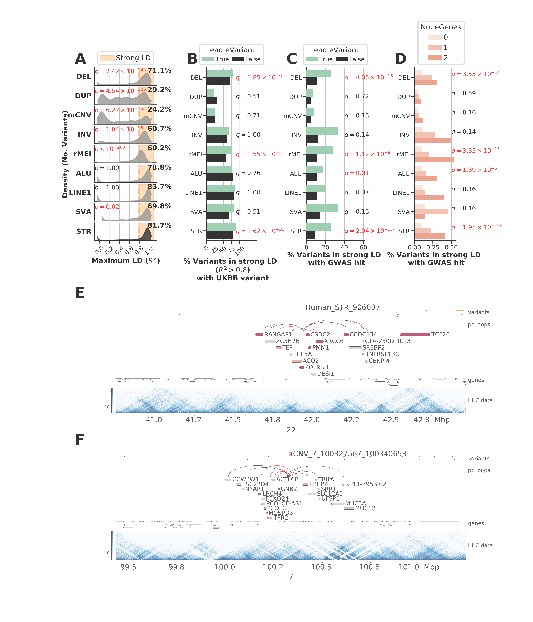

In [17]:
fig =plt.figure(figsize=(6,9), dpi = 100)
gs = mpl.gridspec.GridSpec(3, 4, 
                           figure =fig,
                           width_ratios=[1.5, 1.2, 1.4, 1], 
                           height_ratios = [0.5,0.5, 3], wspace = 0.5, hspace=0)



subgrid_bb = mpl.gridspec.GridSpecFromSubplotSpec(9,1, subplot_spec= gs[0:2,0], wspace=0.3,
                                               hspace= 0.1, width_ratios = [1])


ax2 = fig.add_subplot(gs[0:2,1])
ax3 = fig.add_subplot(gs[0:2, 2])

ax4 = fig.add_subplot(gs[0:2, 3])


subgrid2 = mpl.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec= gs[2:,:], wspace=0,
                                               hspace= 0)

ax5 =  fig.add_subplot(subgrid2[0])
# ax6 =  fig.add_subplot(subgrid2[1])
# ax5 =  fig.add_subplot(gs[2:,0])

###################### Distributions of LD ############################
axes = []
xticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
for i, svt in enumerate(order_var):
    if i == 0:
        a = fig.add_subplot(subgrid_bb[i: i+1, 0], facecolor = (0,0,0,0))
    
    else:
        a = fig.add_subplot(subgrid_bb[i: i+1, 0], facecolor = (0,0,0,0), sharex = a)
    axes.append(a)
    tdf = pvt[pvt.SVTYPE_NR == svt]
    c =  sns.kdeplot(tdf['r2_max'],ax = a, color = color_pal_comp_to_str[svt], label = "_nolegend_",
                     legend = False, shade = True, lw = 1, cut = 1, bw = 0.05, zorder = 20, alpha = 0.8)
    
    
    sns.despine(ax =a, left = False)
    a.set_yticklabels([])
    a.tick_params(axis = 'y', length = 0)
    a.xaxis.grid(linewidth = 0.5)
    a.set_xticks(xticks)
    a.axvline(0.8, linestyle = '--', color = '#FFB265', lw = 1.5)
#     ax3.axvline
    
    if svt != 'STR':
        a.tick_params(axis = 'x', length = 0)
        plt.setp(a.get_xticklabels(), visible=False)
        
    buffer_lims(a, frac = 0.35, direction='max', axis = 'y')
    
    a.text(-0.05, 0.5, svt, color= 'black', clip_on = False, transform = a.transAxes,
           horizontalalignment='right',  verticalalignment='center', weight = 'bold')
    
    frac = frac_strong_ld.loc[svt, True]
    s = '{:.1%}'.format(frac)
    ymin, ymax = a.get_ylim()
    xmin, xmax = a.get_xlim()
    a.text(0.8, 0.83, s, color= 'black', clip_on = False, transform = a.transAxes,
           horizontalalignment='left',  verticalalignment='center', weight = 'bold', fontsize = 7)
    a.fill_betweenx([ymax, 0], x1 = [0.8, 0.8], 
                    x2 = [1.1, 1.1], color= '#FFB265', 
                    zorder = 0, alpha = 0.5,
                   label = 'Strong LD')
    
    
    text = stats_comp_dists_lower.loc[svt, 'p_bonf']
    c = 'black'
    xloc = 0
    yloc = 0.8
    if svt != 'STR':
        if text < 0.05:
            c = 'red'
            
        if text < 1e-40:
            text = 1e-40
            a.text(xloc, yloc,  r"$p < 10^{-40}$", ha = 'left', va = 'center', 
                   fontsize = 6, transform = a.transAxes, color = c)


        elif text < 0.001:
            s = "%1.2e" % text
            a.text(xloc, yloc,  r"$p = {0:s}$".format(as_si(text, 2)), ha = 'left', va = 'center', 
                   fontsize = 6, transform = a.transAxes, color = c)

        else: 
            s = "%1.2f" % text
            a.text(xloc, yloc, r'$p = %1.2f $' % text, ha = 'left', va = 'center', fontsize = 6, 
                   transform = a.transAxes, color = c)

ax1_b = axes[-1]
ax1_a = axes[0]
ax1_mid = axes[4]
ax1_b.set_xlabel('Maximum LD ($R^2$)')
ax1_b.tick_params(axis = 'x', labelrotation = 45)
leg = ax1_a.legend(bbox_to_anchor = (0.5,1), loc = 'lower center')
ax1_mid.set_ylabel('Density (No. Variants)\n\n\n')

################################## Strong LD #####################
pal = {True: '#7DCEA0', False: 'black'}
ax2.xaxis.grid(zorder = 0)
sns.barplot(y = 'SVTYPE_NR', x = 'fraction', data= frac_ld_ukbb[frac_ld_ukbb.strong_ld], 
            hue = 'lead_association', 
            hue_order = [True, False], palette=pal, order = order_var, ax = ax2, zorder = 10)


ax2.set_xlabel('% Variants in strong LD \n ($R^2 > 0.8$) \n with UKBB variant')
ax2.set_ylabel('')
ax2.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax2.set_xlim(0, 1.5)
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1, symbol = None, decimals=0))
sns.despine(ax =ax2, left = False)

ax2.tick_params(axis = 'x', labelrotation = 45)
leg = ax2.legend(fontsize = 6, title = 'lead eVariant', bbox_to_anchor = (0.5, 1), ncol = 2, 
                 loc = 'lower center')
#################### Strong LD With GWAS ################################
ax3.xaxis.grid(zorder = 0)
sns.barplot(y = 'SVTYPE_NR', x = '% with GWAS', data= gwas_frac_svt_th, 
            hue = 'lead_association', 
            hue_order = [True, False], palette=pal, order = order_var, ax = ax3, zorder = 10)


ax3.set_xticks([0, 0.2, 0.4, 0.6])
ax3.set_xlim(0,0.61)
ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1, symbol = None, decimals=0))

ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1, symbol = None, decimals=0))
ax3.set_xlabel('% Variants in strong LD \n with GWAS hit')
ax3.set_ylabel('')
leg = ax3.legend(fontsize = 6, title = 'lead eVariant', bbox_to_anchor = (0.5, 1), ncol = 2, 
                 loc = 'lower center')

sns.despine(ax =ax3, left = False)
###################### Annotate p-values ################
for svt, y in zip(order_var, ax3.get_yticks()):
    text = enr_gwas_ukbb_svt.loc[svt, 'fdr_corrected_p']
    c = 'black'
    xloc = 0.4
    if text < 0.05:
        c = 'red'
    if text < 0.001:
        s = "%1.2e" % text
        ax3.text(xloc, y,  r"$q = {0:s}$".format(as_si(text, 2)), ha = 'left', va = 'center', 
                 color = c, fontsize = 6)
         
       
    else: 
        s = "%1.2f" % text
        ax3.text(xloc, y, r'$q = %1.2f $' % text, ha = 'left', va = 'center', fontsize = 6, color = c)

for svt, y in zip(order_var, ax2.get_yticks()):
    text = enr_overall_ld_evar.loc[svt, 'fdr_corrected_p']
    c = 'black'
    if text < 0.05:
        c = 'red'
    
    if text < 0.001:
        s = "%1.2e" % text
        ax2.text(0.88, y,  r"$q = {0:s}$".format(as_si(text, 2)), ha = 'left', va = 'center', fontsize = 6, 
                color = c)
         
       
    else: 
        s = "%1.2f" % text
        ax2.text(0.88, y, r'$q = %1.2f $' % text, ha = 'left', va = 'center', fontsize = 6, 
                color = c)
        
        
######################## No. eGenes Per Variant Versus Likelihood to be in Strong LD with GWAS variant ###########
sns.set_palette('Reds')
ax4.xaxis.grid(zorder = 0)
sns.barplot(y = 'SVTYPE_NR', x = 'fraction_gwas', 
            data = vc_gwas_by_class, hue = 'label_num_egenes_lead', 
           ax = ax4, order = order_var, hue_order = ['0', '1', '2+'])

ax4.legend(bbox_to_anchor = (0,1), loc = 'lower left', title = 'No. eGenes')
ax4.set_xlabel('% Variants in strong LD \n with GWAS hit')
ax4.set_ylabel('')
sns.despine(ax = ax4)
ax4.set_xticks([0,0.25,0.5])
x = 0.5
for svt, y in zip(order_var, ax4.get_yticks()):
    p = logit_models_svt_gwas.loc[svt, 'fdr_corrected_p']
    text, c = get_formatted_p_values(p)
    ax4.text(x, y, text, ha = 'left', va = 'bottom', fontsize = 6, 
                color = c)

gs.tight_layout(fig)    
    
im = mpimg.imread(fn_loop_example1)
ax5.imshow(im, zorder = 0, alpha = 0.8)
ax5.set_facecolor('#eaece5')
ax5.set(xticklabels= [], yticklabels =[])
ax5.tick_params(axis = 'both', length = 0)
ax5.set_axis_off()


fig.canvas.draw()

mpltools.offset_keep_bounds(ax5, ax1_b, fig, offset_type= 'bottom', use_offset_edge = True,
                            x = 0, y = -0.5,units = 'inches', offset_from_extents = True)

mpltools.resize_axes(ax5, fig, scale_factor=1.16, expand_top_left=True)

fig.canvas.draw()
ax6 = mpltools.draw_new_ax_offset(ax5, fig, 
                                  bbox_offset=[0,0],
                                  match_height=True, 
                                  match_width=True, 
                                  y = -0.2, units='inches',
                                 offset_from_top_left= True)


im = mpimg.imread(fn_loop_example2)
ax6.imshow(im, zorder = 0, alpha = 0.8, aspect = 'equal')
ax6.set_facecolor('#eaece5')
ax6.set(xticklabels= [], yticklabels =[])
ax6.tick_params(axis = 'both', length = 0)
ax6.set_axis_off()
fig.canvas.draw()
labels = ['A', 'B', 'C', 'D', 'E', 'F']
for i, a in enumerate([axes[0], ax2, ax3, ax4, ax5, ax6]):
    mpltools.label_offset_axes(a, fig, labels[i], x = -20, y = 4)

out_fn = private_out + '/Figure_LD_and_GWAS_v6'
fig.savefig(out_fn, bbox_inches='tight', dpi = 500)